In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from scipy import fftpack, integrate, signal, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

### Subjects

In [5]:
sub_dirs = {
    '546658': r'C:\Users\lesliec\OneDrive - Allen Institute\data\depth_test\mouse546658\estim_ramp_depth_2020-10-29_13-55-50\experiment1\recording1',
    '547868': r'C:\Users\lesliec\OneDrive - Allen Institute\data\depth_test\mouse547868\estim_ramp_depth_2020-12-03_10-39-59\experiment1\recording1',
    '551398': r'C:\Users\lesliec\OneDrive - Allen Institute\data\depth_test\mouse551398\estim_ramp_depth_2020-12-17_12-18-07\experiment1\recording1',
}

In [6]:
## Each sweep was performed at a different depth from the surface (um)
depths = {
    0: 0,
    1: 100,
    2: 200,
    3: 300,
    4: 400,
    5: 500,
    6: 600,
    7: 700,
    8: 800,
    9: 900,
    10: 1000,
    11: 1100,
    12: 1200,
    13: 1300,
    14: 1400,
    15: 1500,
    16: 1600,
    17: 1700,
    18: 1800,
    19: 1500,
    20: 1200,
    21: 900,
}

### Load experiments

In [7]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.


### Load eeg data and gather stim-evoked traces

In [8]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim
sttype = 'biphasic' # can be 'fullscreen', 'auditory', or 'biphasic'

apply_mask = True
apply_car = True
apply_filter_type = 'bandpass'

In [9]:
sub_stim_amps = {}
sub_traces = {}
sub_good_chs = {}
for mousei, expi in sub_exp.items():
    print(expi.mouse)
    # load stim log
    stim_log, good_chs = expi.qualitycheck_trials_chs()
    stim_amps =  np.sort(stim_log.parameter.unique())
    sub_stim_amps[mousei] = stim_amps
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(datai.shape[1])
    
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    
    # get evoked traces, z-score, and durations
    sub_traces[mousei] = {}
    sub_good_chs[mousei] = {}

    for ampi in stim_amps:
        sub_traces[mousei][ampi] = {}
        sub_good_chs[mousei][ampi] = {}
        param_mask = (stim_log.stim_type == sttype) & (stim_log.parameter == ampi)
        for sweepi in np.sort(stim_log.loc[param_mask, 'sweep'].unique()):
            good_chs['biphasic'][ampi][sweepi]
            # get evoked traces
            events = get_stim_events(stim_log, sttype, ampi, sweepi)
            event_traces, event_ts = get_evoked_traces(
                datai,
                tsi,
                events,
                before_event,
                after_event,
                expi.ephys_params['EEG']['sample_rate']
            )
            
            ## Apply common avg reference ##
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, good_chs[sttype][ampi][sweepi], :], axis=1)[:,None,:]

            ## Design Butterworth filter ##
            if apply_filter_type == 'bandpass':
                filtb, filta = signal.butter(
                    3, np.array([0.1, 100])/(expi.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
            elif apply_filter_type == 'lowpass':
                filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='lowpass')

            sub_traces[mousei][ampi][sweepi] = [event_ts, signal.filtfilt(filtb, filta, event_traces, axis=0)]
            sub_good_chs[mousei][ampi][sweepi] = good_chs[sttype][ampi][sweepi]
#             print('Sweep {:d}, {:d} bad chs: {:d}'.format(sweepi, ampi, sub_good_chs[mousei][ampi][sweepi].shape[0]))

    del datai
    del tsi
    del stim_log

546658
547868
551398


## Plotting traces

### Butterfly traces for ind chs at different depths

<IPython.core.display.Javascript object>


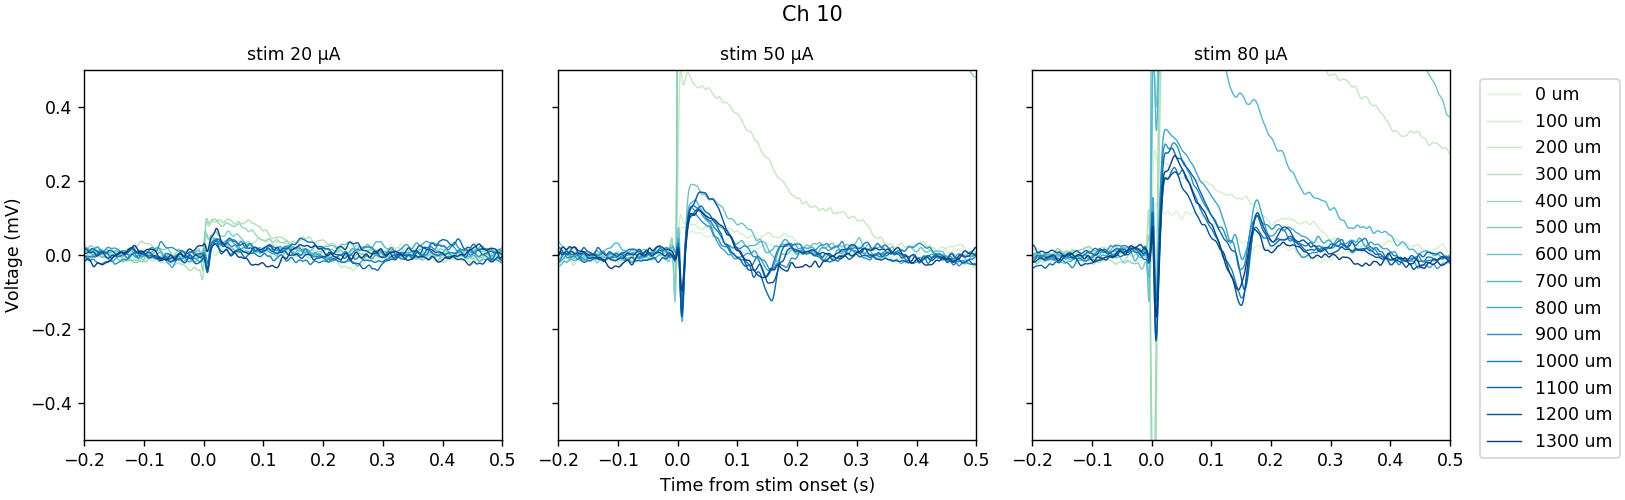

In [79]:
## Plot in subplots
pick_mouse = '546658' # '551398' '546658'
pick_ch = 10
prex = 0.2 # ms before stim to plot
postx = 0.5 # ms after stim to plot
ylimit = 0.5 # mv

fig, axs = plt.subplots(1, len(sub_stim_amps[pick_mouse]), figsize=(13, 4), sharey=True, constrained_layout=True)
for ax, ampi in zip(axs, sub_stim_amps[pick_mouse]):
    
    color_idx = np.linspace(0.15, 1, len(sub_avg_traces[pick_mouse][ampi]))
    for sweepi in range(len(sub_avg_traces[pick_mouse][ampi])):
        pick_traces = sub_avg_traces_filter[pick_mouse][ampi][sweepi][1][:, pick_ch]/1000 # or sub_avg_traces_filter
        pick_times = sub_avg_traces_filter[pick_mouse][ampi][sweepi][0]
        plot_inds = np.squeeze(np.argwhere((pick_times >= -prex) & (pick_times <= postx)))
        
        ax.plot(pick_times[plot_inds], pick_traces[plot_inds], color=plt.cm.GnBu(color_idx[sweepi]), linewidth=0.8, label=('%d um' % depths[sweepi]))
        
    ax.set_xlim([-prex, postx])
    ax.set_ylim([-ylimit, ylimit])
    ax.set_title('stim %d \u03BCA' % ampi)
axs[0].set_ylabel('Voltage (mV)')
axs[1].set_xlabel('Time from stim onset (s)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Ch %d' % pick_ch)
# Save plots?
plot_title = ('Ch%dresponse_alldepths.png' % pick_ch)
# plt.savefig(os.path.join(plotsavedir, plot_title), format='png')

### Plot all ch butterflies per depth

<IPython.core.display.Javascript object>


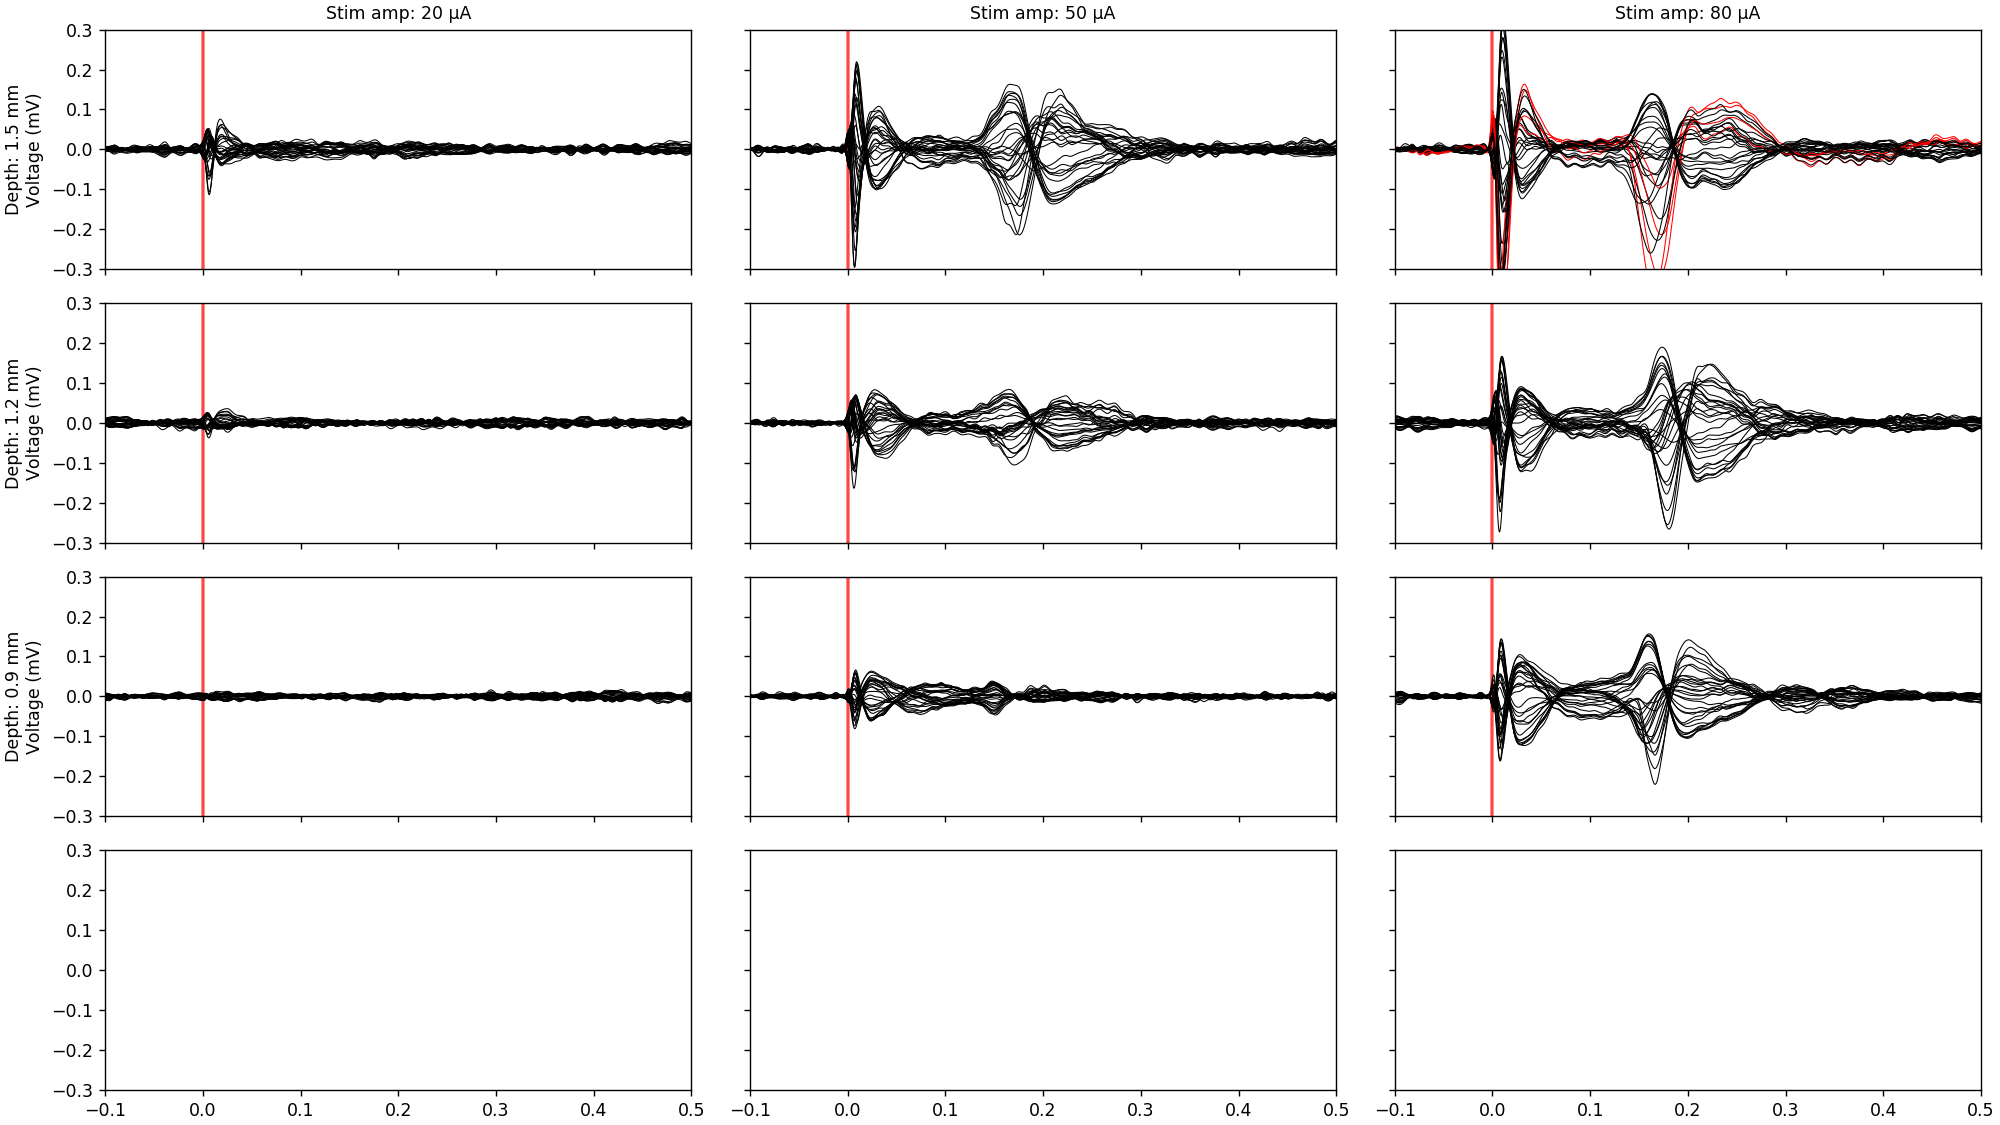

In [17]:
pick_mouse = '551398' #'547868' '546658'
plot_sweeps = [19,20,21]

prex = 0.1 # s before stim to plot
postx = 0.5 # s after stim to plot
ylimit = 0.3 # mv
red_badchs = True

plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+pick_mouse[:6])
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

fig, axs = plt.subplots(4, len(sub_stim_amps[pick_mouse]), figsize=(16, 9), sharex=True, sharey=True, constrained_layout=True)
for i, sweepi in enumerate(plot_sweeps):
    for j, ampi in enumerate(sub_stim_amps[pick_mouse]):
        plottraces = np.mean(sub_traces[pick_mouse][ampi][sweepi][1], axis=2)/1000 # or sub_avg_traces_filter
        timex = sub_traces[pick_mouse][ampi][sweepi][0]
        plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

        if red_badchs:
            for chi in range(plottraces.shape[1]):
                if chi in sub_good_chs[pick_mouse][ampi][sweepi]:
                    axs[i,j].plot(timex[plot_inds], plottraces[plot_inds,chi], color='k', linewidth=0.6)
                else:
                    axs[i,j].plot(timex[plot_inds], plottraces[plot_inds,chi], color='r', linewidth=0.6)
        else:
            axs[i,j].plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
        
        axs[i,j].axvspan(-.001, .001, color='r', alpha=0.5)
        if j == 0:
            axs[i,j].set_ylabel('Depth: {:.1f} mm\nVoltage (mV)'.format(depths[sweepi]/1000))
        if i == 0:
            axs[i,j].set_title('Stim amp: {} \u03BCA'.format(ampi))
        
axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-ylimit, ylimit])

## Save plots?
plot_title = ('depth_CARbfs_{:d}-{:d}.png'.format(depths[plot_sweeps[0]], depths[plot_sweeps[-1]]))
# plt.savefig(os.path.join(plotsavedir, plot_title), format='png')

## Quantify evoked responses

In [18]:
comboplot_save_dir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\depth_test'

In [19]:
mouse_colors = {'546658': 'tab:blue', '547868': 'tab:orange', '551398': 'tab:purple'}
amp_markers = {20: '.', 50: '*', 80: 'o'}
amp_ls = {20: 'dotted', 50: 'solid', 80: 'dashed'}

### Plot bad ch count

In [20]:
sub_badch_nums = {}
for mousei in sub_good_chs.keys():
    sub_badch_nums[mousei] = {}
    for ampi in sub_good_chs[mousei].keys():
        depth_list = []
        chcount = []
        for sweepi in sub_good_chs[mousei][ampi].keys():
            chcount.append(30-len(sub_good_chs[mousei][ampi][sweepi]))
            depth_list.append(depths[sweepi]/1000)
            
        sub_badch_nums[mousei][ampi] = [np.array(depth_list), np.array(chcount)]

<IPython.core.display.Javascript object>


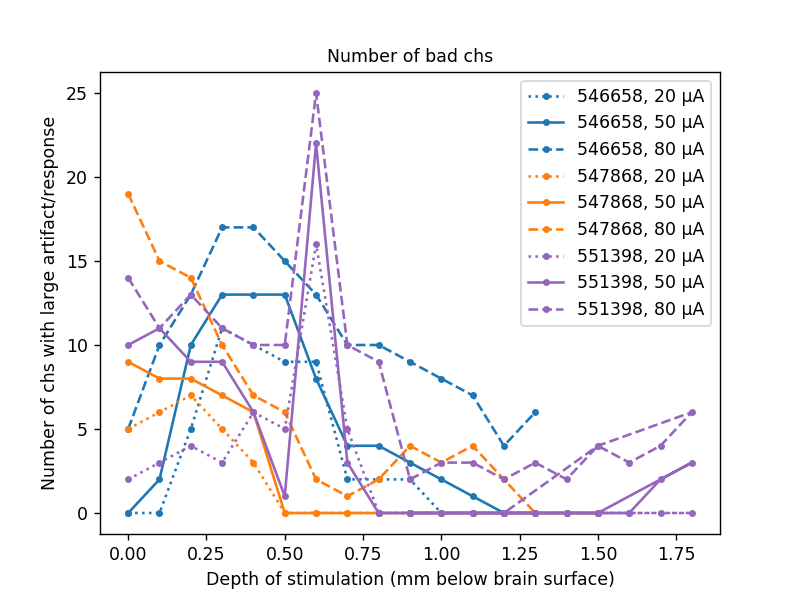

In [21]:
fig, ax = plt.subplots()
for mousei in sub_badch_nums.keys():
    for ampi, datai in sub_badch_nums[mousei].items():
        ax.plot(
            datai[0],
            datai[1],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('Number of chs with large artifact/response')
ax.set_title('Number of bad chs')
ax.legend()

# plt.savefig(os.path.join(comboplot_save_dir, 'BadChcount_vs_depth.png'), format='png')

### Area under rectified curves, all electrodes

In [22]:
AUC_window = [0.005, 0.5] # [0.1, 0.2]

AUC_list = []
depth_list = []
amp_list = []
ch_list = []
m_list = []
for mousei, ampdict in sub_traces.items():
    for ampi, sweepdict in ampdict.items():
        for sweepi, tracedict in sweepdict.items():
            timex = tracedict[0]
            trial_avg_traces = np.mean(tracedict[1], axis=2)
            preinds = np.nonzero((timex >= -AUC_window[1]) & (timex <= -AUC_window[0]))[0]
            postinds = np.nonzero((timex >= AUC_window[0]) & (timex <= AUC_window[1]))[0]
            
            # calc auc #
            baseline_auc = integrate.simps(np.abs(trial_avg_traces[preinds, :]), timex[preinds], axis=0, even='last')
            response_auc = integrate.simps(np.abs(trial_avg_traces[postinds, :]), timex[postinds], axis=0, even='last')
            
            AUC_list.append(response_auc - baseline_auc)
            depth_list.append([depths[sweepi]/1000] * eegchs.shape[0])
            amp_list.append([ampi] * eegchs.shape[0])
            ch_list.append(eegchs)
            m_list.append([mousei] * eegchs.shape[0])

AUC_df = pd.DataFrame({
    'response_mag': np.concatenate(AUC_list),
    'electrode': np.concatenate(ch_list),
    'stim_amp': np.concatenate(amp_list),
    'depth': np.concatenate(depth_list),
    'mouse': np.concatenate(m_list)
})

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


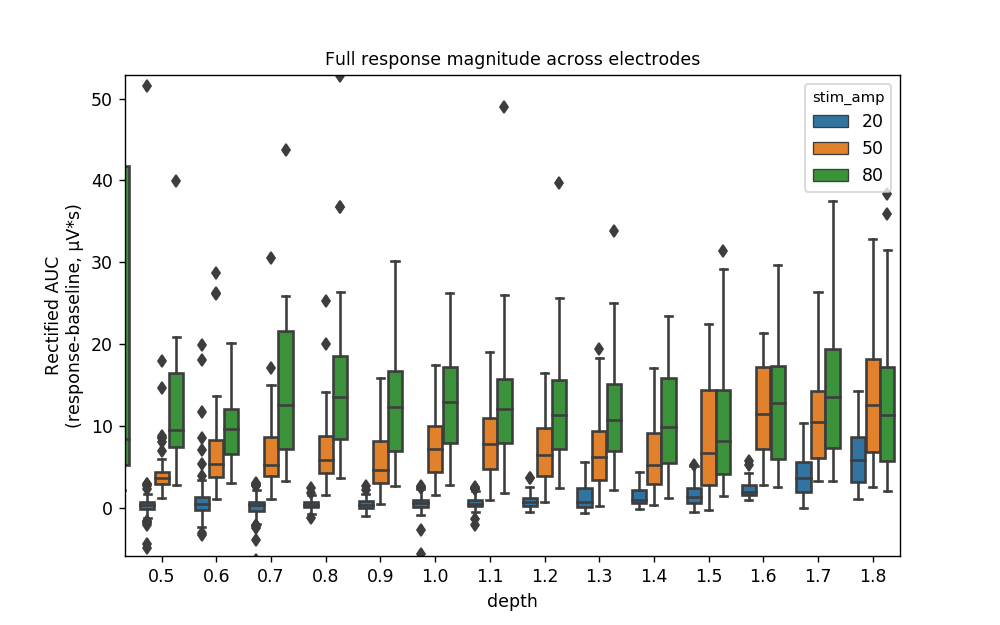

Text(0.5, 1.0, 'Full response magnitude across electrodes')

In [23]:

## Box plot for AUC ##
fig, ax = plt.subplots(figsize=(8,5))
bxplt = sns.boxplot(
    x='depth',
    y='response_mag',
    hue='stim_amp',
    data=AUC_df, #.loc[AUC_df.electrode == 20, :],
    ax=ax,
#     showmeans=True,
#     meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'white', 'markersize':'8'}
)
# bxplt.set_xlabel('Stimulation amplitude (\u03BCA)')
bxplt.set_ylabel('Rectified AUC\n(response-baseline, \u03BCV*s)')
bxplt.set_title('Full response magnitude across electrodes')

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'Response5-500ms_AUC_goodchs.png'), transparent=True)

### Z-score response duration summed across electrodes, whole response (0.001-0.5 s)

Testing

In [26]:
z_threshold = 3
good_chs_only = True
sub_AUC_zscore = {}
for mousei, ampdict in sub_traces.items():
    sub_AUC_zscore[mousei] = {}
    for ampi, sweepdict in ampdict.items():
        depth_list = []
        AUC_list = []
        for sweepi, tracedict in sweepdict.items():
            timex = tracedict[0]
            baseline_inds = np.squeeze(np.argwhere((timex >= -0.5) & (timex <= -0.001)))
            response_inds = np.squeeze(np.argwhere((timex >= 0.001) & (timex <= 0.5)))
            if good_chs_only:
                good_chs = sub_good_chs[mousei][ampi][sweepi]
                plot_tag = 'onlygood'
            else:
                good_chs = np.arange(30)
                plot_tag = 'all'
            traces = tracedict[1][:, good_chs]
            
            ## Find z-score of evoked response ##
            z_traces = (traces - np.mean(traces[baseline_inds,:], axis=0)) / np.std(traces[baseline_inds,:], axis=0)
            
            ## Duration of evoked response > 3 ##
#             AUC_list.append(np.sum(integrate.simps(np.abs(traces[response_inds, :]), timex[response_inds], axis=0, even='last')))
            AUC_list.append(np.median(np.sum(np.abs(z_traces[response_inds,:]) > z_threshold, axis=0) / 2500))
            depth_list.append(depths[sweepi]/1000)
            
        sub_AUC_zscore[mousei][ampi] = [np.array(depth_list), np.array(AUC_list)]

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


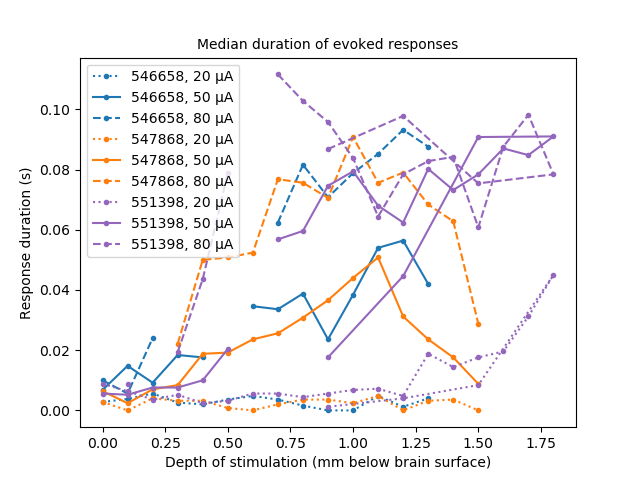

In [27]:
fig, ax = plt.subplots()
for mousei in sub_AUC_zscore.keys():
    for ampi, datai in sub_AUC_zscore[mousei].items():
        ax.plot(
            datai[0],
            datai[1],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('Response duration (s)')
ax.set_title('Median duration of evoked responses')
ax.legend()

# plt.savefig(os.path.join(comboplot_save_dir, 'Zscore_responsedur_vs_depth_{:s}.png'.format(plot_tag)), format='png')

### Peak to trough in second peak window

In [29]:
speak_win = [0.1, 0.2]

good_chs_only = True
pk_tr = {}
pk_tr_maxch = {}
for mousei, ampdict in sub_traces.items():
    pk_tr[mousei] = {}
    pk_tr_maxch[mousei] = {}
    for ampi, sweepdict in ampdict.items():
        depth_list = []
        pk_tr_list = []
        pk_tr_max_list = []
        for sweepi, tracedict in sweepdict.items():
            timex = tracedict[0]
            traces = np.mean(tracedict[1], axis=2)
            response_inds = np.squeeze(np.argwhere((timex >= speak_win[0]) & (timex <= speak_win[1])))
            if good_chs_only:
                good_chs = sub_good_chs[mousei][ampi][sweepi]
                pk_tr_max_list.append(np.max(np.max(traces[response_inds,:][:,good_chs], axis=0) - np.min(traces[response_inds,:][:,good_chs], axis=0)))
                plot_tag = 'good'
            else:
                pk_tr_max_list.append(np.max(np.max(traces[response_inds, :], axis=0) - np.min(traces[response_inds, :], axis=0)))
                plot_tag = 'all'
            
            ## Integrate response window ##
            pk_tr_list.append(np.max(traces[response_inds, :], axis=0) - np.min(traces[response_inds, :], axis=0))
            depth_list.append(depths[sweepi]/1000)
            
        pk_tr[mousei][ampi] = [np.array(depth_list), np.array(pk_tr_list)]
        pk_tr_maxch[mousei][ampi] = [np.array(depth_list), np.array(pk_tr_max_list)]

C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


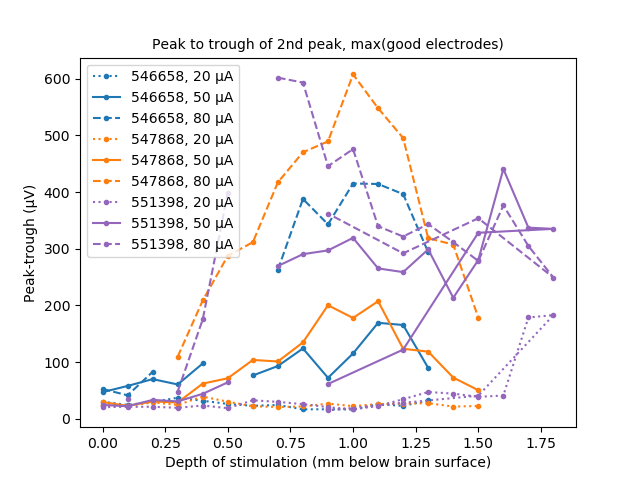

In [30]:
fig, ax = plt.subplots()
for mousei in pk_tr_maxch.keys():
    for ampi, datai in pk_tr_maxch[mousei].items():
        ax.plot(
            datai[0],
            datai[1],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('Peak-trough (\u03BCV)')
ax.set_title('Peak to trough of 2nd peak, max({:s} electrodes)'.format(plot_tag))
ax.legend()

# plt.savefig(os.path.join(comboplot_save_dir, 'medianAUC2ndpeak_vs_depth_{:s}.png'.format(plot_tag)), format='png')

<IPython.core.display.Javascript object>


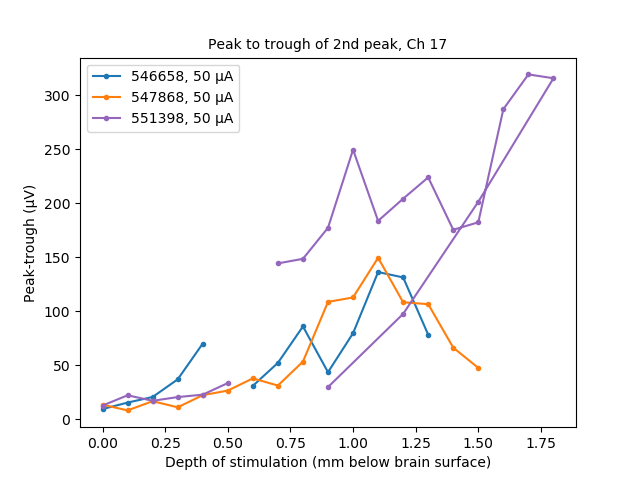

In [34]:
## peak to trough on one channel ##
cha = 17
fig, ax = plt.subplots()
for mousei in pk_tr.keys():
#     for ampi, datai in pk_tr[mousei].items():
    for ampi in [50]:
        datai = pk_tr[mousei][ampi]
        ax.plot(
            datai[0],
            datai[1][:, cha],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('Peak-trough (\u03BCV)')
ax.set_title('Peak to trough of 2nd peak, Ch {:d}'.format(cha))
ax.legend()

# plt.savefig(os.path.join(comboplot_save_dir, 'peak-trough_2ndpeak_vs_depth_50uA_ch{:d}.png'.format(cha)), format='png')

### PCIst and number of PCs

In [36]:
PCI_params = {
    'baseline_window':(-0.5, -0.005), # s before stim for baseline
    'response_window':(0.005, 0.5), # s after stim for response
    'k':1.2,
    'min_snr':1.6, # default 1.1, IR uses 1.6
    'max_var':99,
    'embed':False,
    'n_steps':100,
}

sub_PCIst = {}
sub_numPCs = {}
for mousei, ampdict in sub_traces.items():
    print(mousei)
    start = time.time()
    sub_PCIst[mousei] = {}
    sub_numPCs[mousei] = {}
    for ampi, sweepdict in ampdict.items():
        depth_list = []
        PCI_list = []
        numPC_list = []
        for sweepi, tracedict in sweepdict.items():
            good_chs = sub_good_chs[mousei][ampi][sweepi]
            timex = tracedict[0]
            traces = np.mean(tracedict[1], axis=2)[:, good_chs]
            
            full_PCI = calc_PCIst(traces.T, timex, full_return=True, **PCI_params)
            depth_list.append(depths[sweepi]/1000)
            PCI_list.append(full_PCI['PCI'])
            numPC_list.append(full_PCI['n_dims'])
            
        sub_PCIst[mousei][ampi] = [np.array(depth_list), np.array(PCI_list)]
        sub_numPCs[mousei][ampi] = [np.array(depth_list), np.array(numPC_list)]
    end = time.time()
    print('Time to calculate PCI for all amps: {:0.2f} min'.format((end-start)/60))

546658
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
No components --> PCIst=0
Data contains nan values.


TypeError: 'int' object is not subscriptable

In [39]:
print(traces.shape)

(5000, 17)


In [43]:
print(ampi)
print(sweepi)

50
5


<IPython.core.display.Javascript object>


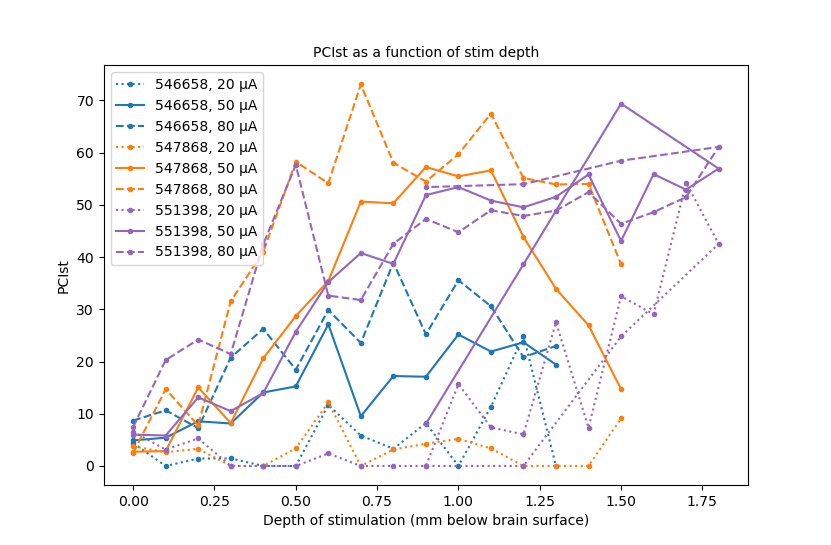

In [18]:
## Plot PCI values ##
fig, ax = plt.subplots()
for mousei in sub_PCIst.keys():
    for ampi, datai in sub_PCIst[mousei].items():
#     for ampi in [50]:
#         datai = sub_PCIst[mousei][ampi]
        ax.plot(
            datai[0],
            datai[1],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('PCIst')
ax.set_title('PCIst as a function of stim depth')
ax.legend()

# plt.savefig(os.path.join(comboplot_save_dir, 'PCIst_vs_depth_allgoodchs.png'), format='png')

<IPython.core.display.Javascript object>


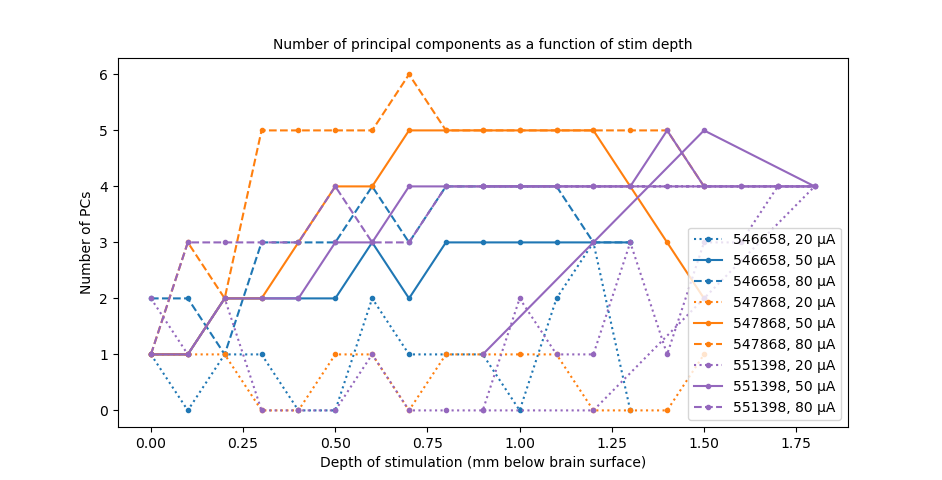

In [19]:
## Plot number of PCs ##
fig, ax = plt.subplots()
for mousei in sub_numPCs.keys():
    for ampi, datai in sub_numPCs[mousei].items():
        ax.plot(
            datai[0],
            datai[1],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('Number of PCs')
ax.set_title('Number of principal components as a function of stim depth')
ax.legend()

# plt.savefig(os.path.join(comboplot_save_dir, 'numPCs_vs_depth_allgoodchs.png'), format='png')

### Area under abs(average) curve summed across electrodes, whole response (0.001-0.5 s)

This doesn't appear to work...first, it picks up extremely high values for depths that have known artifact. Second, this method of finding the area under the absolute curve would amplify the contribution of small fluctuations in the response, not necessarily evoked response.

In [27]:
good_chs_only = False
sub_AUC = {}
for mousei, ampdict in sub_avg_traces_filter.items():
    sub_AUC[mousei] = {}
    for ampi, sweepdict in ampdict.items():
        depth_list = []
        AUC_list = []
        for sweepi, tracedict in sweepdict.items():
            timex = tracedict[0]
            response_inds = np.squeeze(np.argwhere((timex >= 0.001) & (timex <= 0.5)))
            if good_chs_only:
                good_chs = [x for x in np.arange(30) if x not in sub_bad_chs[mousei][ampi][sweepi]]
                plot_tag = 'onlygood'
            else:
                good_chs = np.arange(30)
                plot_tag = 'all'
            traces = tracedict[1][:, good_chs]
            
            ## Integrate response window ##
            AUC_list.append(integrate.simps(np.abs(traces[response_inds, :]), timex[response_inds], axis=0, even='last'))
            depth_list.append(depths[sweepi]/1000)
            
        sub_AUC[mousei][ampi] = [np.array(depth_list), np.array(AUC_list)]

<IPython.core.display.Javascript object>


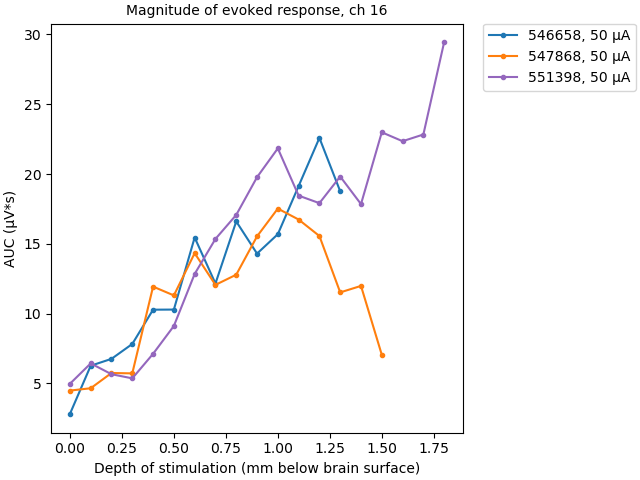

In [41]:
cha = 16 # 25
fig, ax = plt.subplots(constrained_layout=True)
for mousei in sub_AUC.keys():
#     for ampi, datai in sub_AUC[mousei].items():
    for ampi in [50]:
        datai = sub_AUC[mousei][ampi]
        if mousei == '551398':
            plotinds = np.arange(19)
        else:
            plotinds = datai[0] < 1.8
        ax.plot(
            datai[0][plotinds],
            datai[1][plotinds, cha],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('AUC (\u03BCV*s)')
ax.set_title('Magnitude of evoked response, ch {:d}'.format(cha))
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig(os.path.join(comboplot_save_dir, 'singlechAUC_vs_depth.png'), format='png')

### Area under average curve summed across electrodes, whole response (0.001-0.5 s)

This doesn't appear to work...again, it picks up high values for depths that have known artifact. Second, finding the area under the curve (without taking the absolute value first) would result in low values when the response has a signiicant positive and negative part of the evoked response.

### Area under abs(average) curve summed across electrodes, 2nd peak (0.1-0.2 s)

This works the best so far. But it is still swamped by the AUC from depths that have a lot of artifact.

In [65]:
good_chs_only = True
sub_AUC = {}
for mousei, ampdict in sub_avg_traces_filter.items():
    sub_AUC[mousei] = {}
    for ampi, sweepdict in ampdict.items():
        depth_list = []
        AUC_list = []
        for sweepi, tracedict in sweepdict.items():
            timex = tracedict[0]
            response_inds = np.squeeze(np.argwhere((timex >= 0.1) & (timex <= 0.2)))
            if good_chs_only:
                good_chs = [x for x in np.arange(30) if x not in sub_bad_chs[mousei][ampi][sweepi]]
                plot_tag = 'onlygood'
            else:
                good_chs = np.arange(30)
                plot_tag = 'all'
            traces = tracedict[1][:, good_chs]
            
            ## Integrate response window ##
            AUC_list.append(np.sum(integrate.simps(np.abs(traces[response_inds, :]), timex[response_inds], axis=0, even='last')))
            depth_list.append(depths[sweepi]/1000)
            
        sub_AUC[mousei][ampi] = [np.array(depth_list), np.array(AUC_list)]

<IPython.core.display.Javascript object>


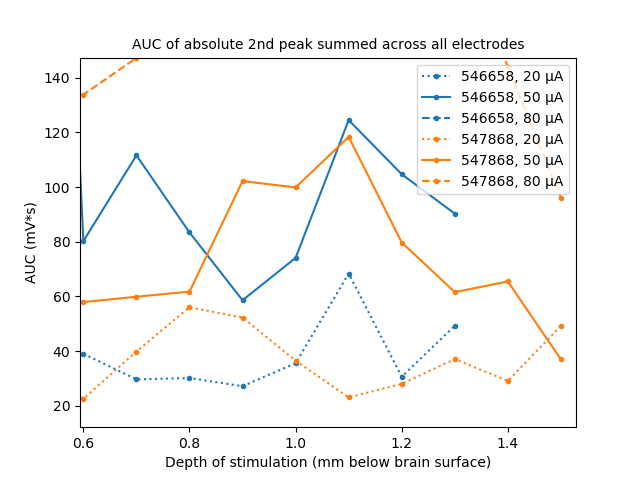

In [66]:
fig, ax = plt.subplots()
for mousei in sub_AUC.keys():
    for ampi, datai in sub_AUC[mousei].items():
        ax.plot(
            datai[0],
            datai[1],
            color=mouse_colors[mousei],
            marker='.',
            linestyle=amp_ls[ampi],
            label='{:s}, {:d} \u03BCA'.format(mousei, ampi)
        )
ax.set_xlabel('Depth of stimulation (mm below brain surface)')
ax.set_ylabel('AUC (mV*s)')
ax.set_title('AUC of absolute 2nd peak summed across all electrodes')
ax.legend()

# plt.savefig(os.path.join(comboplot_save_dir, 'medianAUC2ndpeak_vs_depth_{:s}.png'.format(plot_tag)), format='png')

### Get response durations

In [29]:
z_threshold = 3

mlabels = []
trace_duration_means = {}
trace_mean_durations = {}
all_ch_durations = []
for mousei, expi in sub_exp.items():
    tdms = []
    tmds = []
    for ampi in sub_stim_amps[mousei]:
        for sweepi in awake_sweeps[mousei]:
            event_zscore = sub_zscores[mousei][ampi][sweepi]
            # find duration of each trial, then average later
            trace_durs = np.sum(np.abs(event_zscore[event_ts>1.,:,:]) > z_threshold, axis=0) / expi.ephys_params['EEG']['sample_rate']
            # find average zscore, then find duration
            tracemean_dur = np.sum(np.abs(np.mean(event_zscore, axis=2)[event_ts>1.,:]) > z_threshold, axis=0) / expi.ephys_params['EEG']['sample_rate']
            ## make labels and array for box plot
#             mlabels.append(mousei+'_'+str(ampi)+'_'+str(sweepi))
            mlabels.append(str(ampi))
            all_ch_durations.append(trace_durs)
            tdms.append(np.mean(trace_durs, axis=1))
            tmds.append(tracemean_dur)
    trace_duration_means[mousei] = np.array(tdms)
    trace_mean_durations[mousei] = np.array(tmds)
print(np.shape(trace_duration_means[mousei]))

(8, 32)


In [25]:
print(np.shape(all_ch_durations[0]))

(32, 60)


<IPython.core.display.Javascript object>


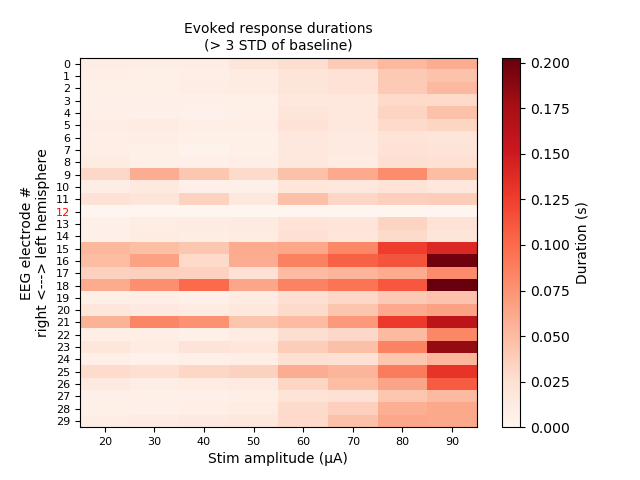

In [36]:
# calculated zscore for each ch/amp/trial, then found duration of responses > z_threshold, took mean across trials
pick_mouse = '546657a'
pick_sweep = 0
set_vrange = 0.3 # s
mask_bad_chs = True

plot_mean_dur = trace_duration_means[pick_mouse][:, realchs].T
if mask_bad_chs:
    mask_traces = np.zeros((len(bad_chs[pick_mouse]), np.shape(plot_mean_dur)[1]))
    plot_mean_dur[bad_chs[pick_mouse],:] = mask_traces

fig, ax = plt.subplots()
resp_dur = ax.imshow(plot_mean_dur,
                     cmap='Reds',
                     aspect='auto',
#                      vmin=0,
#                      vmax=set_vrange,
#                      norm=LogNorm(vmin=0.01, vmax=0.3),
                     interpolation='none',
                    )
ax.set_yticks(np.arange(len(realchs)))
ax.set_yticklabels(realchs, fontsize=8)
for ytick in ax.get_yticklabels():
    if int(ytick.get_text()) in bad_chs[pick_mouse]:
        ytick.set_color('r')
ax.set_xticks(np.arange(len(sub_stim_amps[pick_mouse])))
ax.set_xticklabels(sub_stim_amps[pick_mouse], fontsize=8)
ax.set_title('Evoked response durations\n(> %d STD of baseline)' % z_threshold)
ax.set_xlabel('Stim amplitude (\u03BCA)')
ax.set_ylabel('EEG electrode #\nright <---> left hemisphere')
cbar = plt.colorbar(resp_dur)
cbar.set_label('Duration (s)')

### Peak-to-peak voltage

In [33]:
windows = [(1, 5), (5, 20)] # time windows in ms (positive, negative peak, respectively)
mean_peak_mags = {}
all_peak_mags = {}
for mousei, expi in sub_exp.items():
    all_peak_mags[mousei] = []
    mean_peak_diffs = []
    for ampi in sub_stim_amps[mousei]:
        peak_diffs = []
        for sweepi in awake_sweeps[mousei]:
            ## get time inds
            first_inds = np.argwhere((sub_timex[mousei][ampi][sweepi] > windows[0][0]) & (sub_timex[mousei][ampi][sweepi] < windows[0][1])).flatten()
            second_inds = np.argwhere((sub_timex[mousei][ampi][sweepi] > windows[1][0]) & (sub_timex[mousei][ampi][sweepi] < windows[1][1])).flatten()
            ## find peaks
            first_peak = np.max(sub_traces[mousei][ampi][sweepi][first_inds,:,:], axis=0)
            second_peak = np.min(sub_traces[mousei][ampi][sweepi][second_inds,:,:], axis=0)
            ## append max - min
            peak_diffs.append(first_peak-second_peak)
            
        all_peak_mags[mousei].append(np.concatenate(peak_diffs, axis=0))
        mean_peak_diffs.append(np.mean(np.concatenate(peak_diffs, axis=0), axis=1))
    mean_peak_mags[mousei] = np.array(mean_peak_diffs)
    
# print(np.shape(mean_peak_mags['543396a']))

<IPython.core.display.Javascript object>


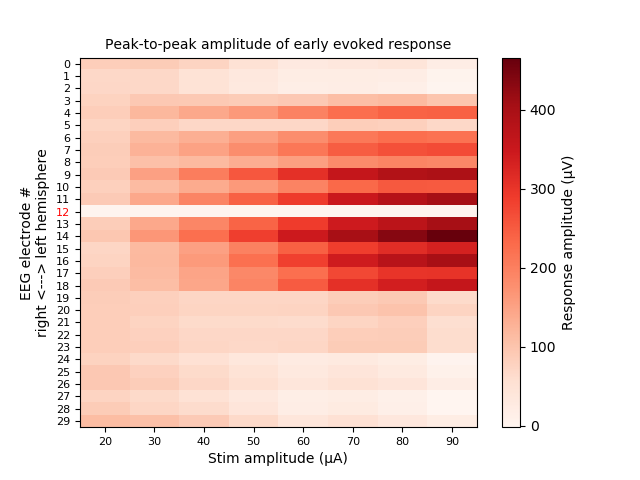

In [34]:
# calculated peak-to-peak for each ch/amp/trial, then found mean across trials
pick_mouse = '546657a'
# set_vrange = 0.15 # s
mask_bad_chs = True

plot_peak_mean = mean_peak_mags[pick_mouse][:, realchs].T
if mask_bad_chs:
    mask_traces = np.zeros((len(bad_chs[pick_mouse]), np.shape(plot_peak_mean)[1]))
    plot_peak_mean[bad_chs[pick_mouse],:] = mask_traces

fig, ax = plt.subplots()
peak_mean = ax.imshow(plot_peak_mean,
                     cmap='Reds',
                     aspect='auto',
#                      vmin=0,
#                      vmax=set_vrange,
#                      norm=LogNorm(vmin=0.01, vmax=0.3),
                     interpolation='none',
                    )
ax.set_yticks(np.arange(len(realchs)))
ax.set_yticklabels(realchs, fontsize=8)
for ytick in ax.get_yticklabels():
    if int(ytick.get_text()) in bad_chs[pick_mouse]:
        ytick.set_color('r')
ax.set_xticks(np.arange(len(sub_stim_amps[pick_mouse])))
ax.set_xticklabels(sub_stim_amps[pick_mouse], fontsize=8)
ax.set_title('Peak-to-peak amplitude of early evoked response')
ax.set_xlabel('Stim amplitude (\u03BCA)')
ax.set_ylabel('EEG electrode #\nright <---> left hemisphere')
cbar = plt.colorbar(peak_mean)
cbar.set_label('Response amplitude (\u03BCV)')

<IPython.core.display.Javascript object>


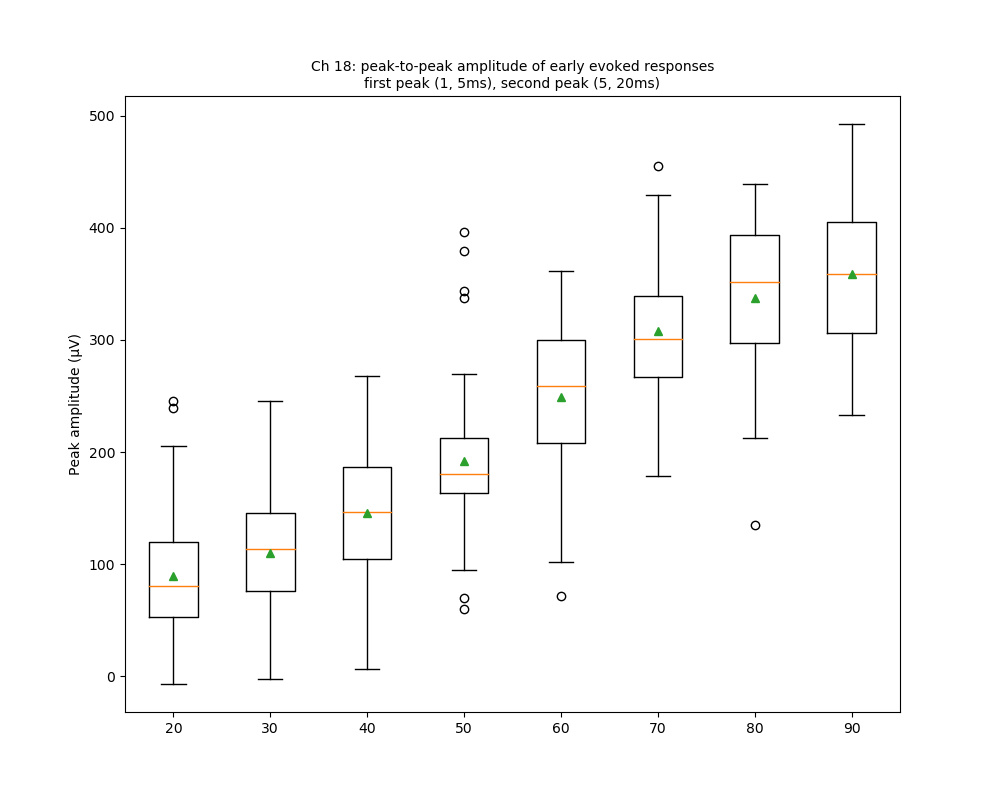

Text(0.5, 1.0, 'Ch 18: peak-to-peak amplitude of early evoked responses\nfirst peak (1, 5ms), second peak (5, 20ms)')

In [35]:
# makes boxplot for single ch, to see spread of peaks
plch = 18
pl_pks = [x[plch,:] for x in all_peak_mags[pick_mouse]]
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(pl_pks, showmeans=True, labels=sub_stim_amps[pick_mouse])
# plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
# ax.set_ylim([-0.005, 0.3])
ax.set_ylabel('Peak amplitude (\u03BCV)')
ax.set_title('Ch %d: peak-to-peak amplitude of early evoked responses\nfirst peak (%d, %dms), second peak (%d, %dms)' % (plch, windows[0][0], windows[0][1], windows[1][0], windows[1][1]))